# 라이브러리 Import

In [3]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

# 학습 데이터 병합

In [4]:
zip_path1 = "/content/train4a.zip" # ZIP 파일 경로
extract_path1 = "/content/train4a/"  # 압축 해제 경로

shutil.unpack_archive(zip_path1, extract_path1)

In [5]:
fixed_file_path = "/content/merged_pedestrian_behavior.csv"

In [6]:
# 보행자 CSV 파일이 저장된 폴더 경로
data_folder = "/content/train4a/train4a"

# 모든 CSV 파일 찾기
csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# 숫자 기준으로 파일 정렬 (Video_1_dataset.csv → Video_2_dataset.csv → ...)
csv_files_sorted = sorted(csv_files, key=lambda x: int(re.search(r"Video_(\d+)_dataset\.csv", x).group(1)) if re.search(r"Video_(\d+)_dataset\.csv", x) else float('inf'))

# 모든 CSV 파일 로드 및 frame 컬럼 추가
all_dataframes = []

print("CSV 파일 로드 시작...")

for filename in csv_files_sorted:
    file_path = os.path.join(data_folder, filename)

    # 파일 로드 로그 출력
    print(f"처리 중: {filename}")

    # 파일 이름에서 pedestrian_id 추출 (예: Video_1_dataset.csv → pedestrian_id = 1)
    match = re.search(r"Video_(\d+)_dataset\.csv", filename)
    if match:
        pedestrian_id = int(match.group(1))  # "Video_1_dataset.csv" → 1

        # CSV 파일 로드
        df = pd.read_csv(file_path, header=None)  # 컬럼명이 없을 수도 있으므로 header=None 사용

        # 입력 데이터 (69개)와 행동 라벨 (마지막 열) 분리
        num_features = 69  # Keypoints(22개) + CoM(3D) = 69차원 입력
        df_features = df.iloc[:, :num_features]  # 69개 입력 피처
        df_labels = df.iloc[:, num_features]  # 마지막 열이 행동 클래스 라벨 (0~3)

        # 컬럼 이름 설정
        keypoint_columns = [f"kp_{i}" for i in range(num_features)]  # "kp_0", "kp_1", ..., "kp_68"
        df_features.columns = keypoint_columns  # 입력 피처 이름 지정
        df_labels.name = "behavior_label"  # 행동 클래스 열 이름 지정

        # 보행자 ID 추가
        df_features["pedestrian_id"] = pedestrian_id

        # 행동 라벨 추가 - 명시적으로 정수형(int)으로 변환
        df_features["behavior_label"] = df_labels

        # frame 컬럼 추가 (0부터 시작하는 인덱스)
        df_features.insert(0, "frame", range(len(df_features)))

        # 리스트에 저장
        all_dataframes.append(df_features)

        # 파일 처리 완료 로그 출력
        print(f"처리 완료: {filename} (Samples: {len(df_features)})")

# 모든 데이터를 하나의 DataFrame으로 합침
full_df = pd.concat(all_dataframes, ignore_index=True)

# 데이터 타입 확인
print("\n데이터 타입 확인:")
for col in ["frame", "pedestrian_id", "behavior_label"]:
    print(f"{col}: {full_df[col].dtype}")

# 행동 라벨 분포 확인
print("\n행동 라벨 분포:")
print(full_df["behavior_label"].value_counts())

CSV 파일 로드 시작...
처리 중: Video_1_dataset.csv
처리 완료: Video_1_dataset.csv (Samples: 203)
처리 중: Video_2_dataset.csv
처리 완료: Video_2_dataset.csv (Samples: 98)
처리 중: Video_3_dataset.csv
처리 완료: Video_3_dataset.csv (Samples: 128)
처리 중: Video_4_dataset.csv
처리 완료: Video_4_dataset.csv (Samples: 146)
처리 중: Video_5_dataset.csv
처리 완료: Video_5_dataset.csv (Samples: 144)
처리 중: Video_6_dataset.csv
처리 완료: Video_6_dataset.csv (Samples: 81)
처리 중: Video_7_dataset.csv
처리 완료: Video_7_dataset.csv (Samples: 59)
처리 중: Video_8_dataset.csv
처리 완료: Video_8_dataset.csv (Samples: 345)
처리 중: Video_9_dataset.csv
처리 완료: Video_9_dataset.csv (Samples: 165)
처리 중: Video_10_dataset.csv
처리 완료: Video_10_dataset.csv (Samples: 125)
처리 중: Video_11_dataset.csv
처리 완료: Video_11_dataset.csv (Samples: 134)
처리 중: Video_12_dataset.csv
처리 완료: Video_12_dataset.csv (Samples: 38)
처리 중: Video_13_dataset.csv
처리 완료: Video_13_dataset.csv (Samples: 159)
처리 중: Video_14_dataset.csv
처리 완료: Video_14_dataset.csv (Samples: 38)
처리 중: Video_15_dataset.csv


In [7]:
# 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# NaN(결측값) 개수 확인
missing_values = numeric_df.isna().sum()
print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# Inf(무한대) 값 확인
infinite_values = np.isinf(numeric_df).sum()
print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

NaN (결측값) 개수:
 kp_1              170
kp_2              170
kp_3              170
kp_4              170
kp_5              170
                 ... 
kp_65             170
kp_66             170
kp_67             170
kp_68             170
behavior_label    170
Length: 69, dtype: int64

Inf (무한대) 개수:
 Series([], dtype: int64)


In [8]:
# 결측치 제거
full_df.dropna(inplace=True)
print("결측값 제거\n")

# 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# NaN(결측값) 개수 확인
missing_values = numeric_df.isna().sum()
print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# Inf(무한대) 값 확인
infinite_values = np.isinf(numeric_df).sum()
print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

결측값 제거

NaN (결측값) 개수:
 Series([], dtype: int64)

Inf (무한대) 개수:
 Series([], dtype: int64)


## Binary Classification

In [9]:
# binary 클래스로 변경
# full_df["behavior_label"] = full_df["behavior_label"].replace({3: 0, 2: 1})

# standing 제외 모두 walking
# full_df["behavior_label"] = full_df["behavior_label"].replace({3: 1, 2: 1})

In [10]:
# 정수로 변환
full_df["behavior_label"] = full_df["behavior_label"].astype(int)

# 최종 데이터 저장
full_df.to_csv(fixed_file_path, index=False)

print("모든 CSV 파일 처리 완료!")
print(f"최종 데이터 저장: {fixed_file_path}")

모든 CSV 파일 처리 완료!
최종 데이터 저장: /content/merged_pedestrian_behavior.csv


## Z좌표 제거, CoM 값 제거

In [11]:
# # Z 좌표 제거
# # cols_to_keep = [0] + [i for i in range(1, (23 * 3) + 1) if (i % 3) != 0] + [71]
# # df_filtered = full_df.iloc[:, cols_to_keep]

# # CoM 좌표 제거
# cols_to_keep = [0] + list(range(1, (22 * 3) + 1)) + [71]
# df_filtered = full_df.iloc[:, cols_to_keep]

# print(df_filtered.columns)
# # 새 CSV 파일로 저장
# df_filtered.to_csv("except_CoM.csv", index=False)

#경로 지정

In [12]:
dataset = '/content/merged_pedestrian_behavior.csv'
model_save_path = '/content/keypoint_classifier.keras'

# 클래스 설정

In [13]:
NUM_CLASSES = 4

# 학습 데이터 로드

In [14]:
def extract_sequences_from_dataframe(
    df,
    sequence_length=20,
    future_offset=0,  # recognization=0, prediction=5
    feature_prefix='kp_',
    label_column='behavior_label',
    group_column='pedestrian_id',
    num_keypoints=23  # keypoint 개수
):
    """
    DataFrame으로부터 시퀀스 데이터를 추출하고, 모델 입력 형식으로 reshape합니다.

    Returns:
        X (np.ndarray): 시퀀스 입력 데이터, shape=(num_seq, sequence_length, num_keypoints * 3)
        y (np.ndarray): 시퀀스 타겟 라벨, shape=(num_seq,)
    """
    feature_cols = [col for col in df.columns if col.startswith(feature_prefix)]
    X, y = [], []

    for ped_id, group in df.groupby(group_column):
        group = group.reset_index(drop=True)

        if len(group) < sequence_length + future_offset:
            continue

        data = group[feature_cols].values  # shape: (num_frames, 69)
        labels = group[label_column].values

        for i in range(len(data) - sequence_length - future_offset + 1):
            seq_x = data[i:i + sequence_length]  # shape: (20, 69)
            seq_y = labels[i + sequence_length + future_offset - 1]
            X.append(seq_x)
            y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    # reshape: (num_seq, 20, 69) → (num_seq, 20, 23 * 3)
    X = X.reshape(-1, sequence_length, num_keypoints * 3)
    return X, y


In [15]:
df = pd.read_csv('/content/merged_pedestrian_behavior.csv')

X, y = extract_sequences_from_dataframe(df)

print("X shape:", X.shape)  # (num_seq, 20, 69)
print("y shape:", y.shape)
print("y 클래스 분포:", np.unique(y, return_counts=True))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size=0.7,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size=0.5,
    stratify=y_temp,
    random_state=42
)

X shape: (6917, 20, 69)
y shape: (6917,)
y 클래스 분포: (array([0, 1, 2, 3]), array([2983,  900, 2264,  770]))


# 모델 생성

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(20, (23 * 3))),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 18, 64)              │          13,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 16, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,532 (181.77 KB)

 Trainable params: 46,532 (181.77 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 모델 체크포인트 콜백
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Early Stopping 콜백
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [19]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 훈련

In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4203 - loss: 1.2698
Epoch 1: val_loss improved from inf to 1.17094, saving model to /content/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4226 - loss: 1.2652 - val_accuracy: 0.5376 - val_loss: 1.1709
Epoch 2/1000
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5160 - loss: 1.1509
Epoch 2: val_loss improved from 1.17094 to 1.07372, saving model to /content/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5180 - loss: 1.1479 - val_accuracy: 0.5674 - val_loss: 1.0737
Epoch 3/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5890 - loss: 1.0482
Epoch 3: val_loss improved from 1.07372 to 1.01362, saving model to /content/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5886 - loss: 1.0482 - val_accuracy: 0.5848 - val_loss: 1.0136
Epoch 4/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6130 - loss: 0.9867

In [21]:
# 모델 평가
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9514 - loss: 0.1206 


In [22]:
# 저장 모델 불러오기
model = tf.keras.models.load_model(model_save_path)

In [23]:
# 모델 predict
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[5.4285876e-10 3.6141938e-09 9.9993265e-01 6.7351153e-05]
2


# 결과 시각화


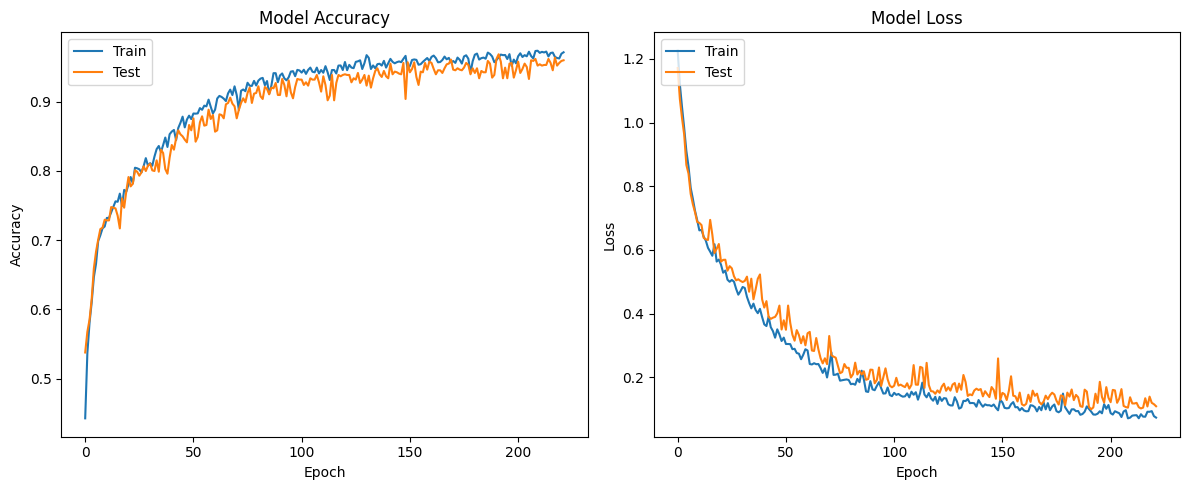

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


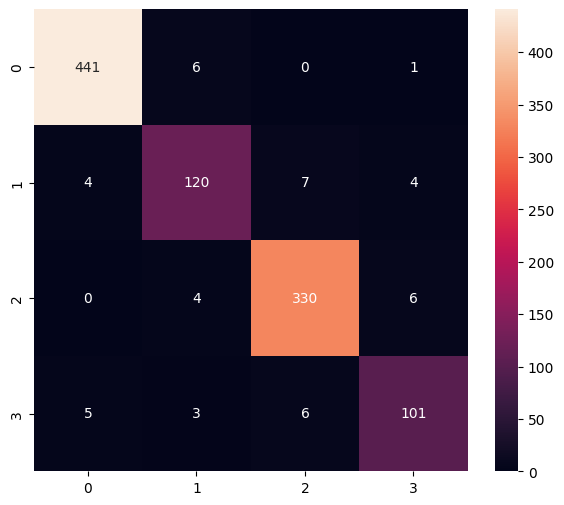

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       448
           1       0.90      0.89      0.90       135
           2       0.96      0.97      0.97       340
           3       0.90      0.88      0.89       115

    accuracy                           0.96      1038
   macro avg       0.94      0.93      0.93      1038
weighted avg       0.96      0.96      0.96      1038



In [25]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


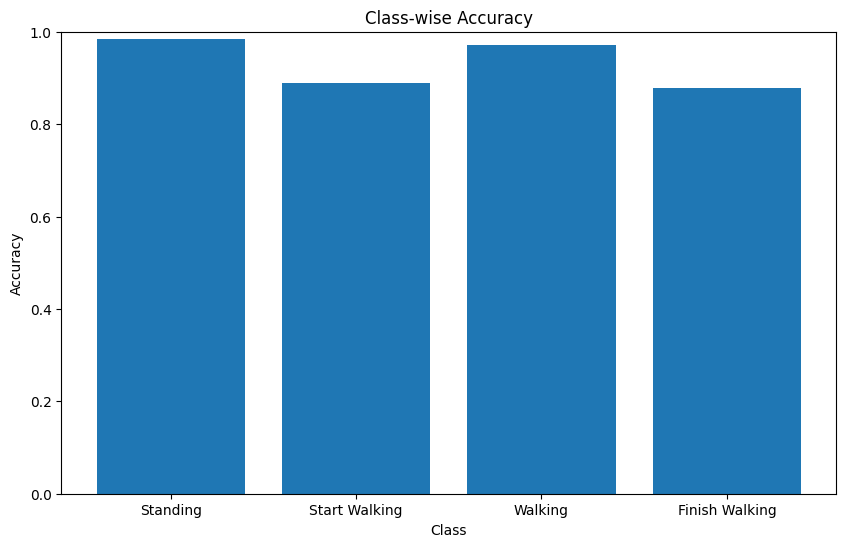

In [26]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

try:
    cm = confusion_matrix(y_test, y_pred)

    # 클래스별 정확도 계산 및 시각화
    class_accuracy = np.zeros(4)  # 0~3 클래스에 대한 정확도 배열 초기화
    for i in range(min(4, len(cm))):
        if cm.sum(axis=1)[i] > 0:  # 0으로 나누기 방지
            class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

    plt.figure(figsize=(10, 6))
    plt.bar(['Standing', 'Start Walking', 'Walking','Finish Walking'], class_accuracy)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)
    plt.show()
except Exception as e:
    print(f"시각화 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

# Tensorflow-Lite용 모델로 변환

In [27]:
# 추론 전용 모델 저장
model.save(model_save_path, include_optimizer=False)

In [28]:
# 경량화
tflite_save_path = '/content/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Saved artifact at '/tmp/tmppwrn5gm9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 69), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133896324522512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324516176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324521360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324520400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324520016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324514832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896324519632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133896322823952: TensorSpec(shape=(), dtype=tf.resource, name=None)


55296

# Inference 테스트

In [29]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [30]:
# input, output tenser 추출
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [31]:
input_data = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [32]:
%%time
# 예측 시간
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 0 ns, sys: 374 µs, total: 374 µs
Wall time: 2.68 ms


In [33]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5621691e-10 3.0505265e-09 9.9993765e-01 6.2392981e-05]
2
